In [96]:
import arff
import pprint

import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

from sklearn.metrics import silhouette_score

In [88]:
#TODO: Use another file than the preprocessed.pkl
with open('preprocessed.pkl', 'rb') as f:
    data = pickle.load(f)
    print(data)
    print(len(data))
    


      has_null  wave  gender   age  age_o  d_age  d_d_age  race  race_o  \
0            0   1.0       0  21.0   27.0    6.0        2     0       2   
1            0   1.0       0  21.0   22.0    1.0        0     0       2   
2            1   1.0       0  21.0   22.0    1.0        0     0       0   
3            0   1.0       0  21.0   23.0    2.0        1     0       2   
4            0   1.0       0  21.0   24.0    3.0        1     0       3   
...        ...   ...     ...   ...    ...    ...      ...   ...     ...   
8373         1  21.0       1  25.0   26.0    1.0        0     2       3   
8374         1  21.0       1  25.0   24.0    1.0        0     2       4   
8375         1  21.0       1  25.0   29.0    4.0        2     2       3   
8376         1  21.0       1  25.0   22.0    3.0        1     2       0   
8377         1  21.0       1  25.0   22.0    3.0        1     2       0   

      samerace  ...  d_expected_num_interested_in_me  d_expected_num_matches  \
0            0  ...

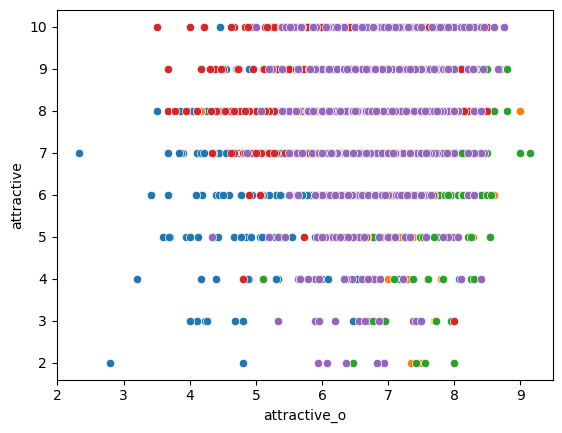

In [102]:
self_rated_features = ['attractive', 'sincere', 'intelligence', 'funny', 'ambition']
average_columns = [ 'attractive_o', 'sinsere_o', 'intelligence_o', 'funny_o', 'ambitous_o']
group_by_columns = ['gender', 'age', 'race', 'field', 'attractive_important', 'sincere_important', 'intellicence_important', 'funny_important', 'ambtition_important', 'shared_interests_important', 'attractive', 'sincere', 'intelligence', 'funny', 'ambition', 'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga']
#rating_data = data[self_rated_features + average_columns]

def compare_ratings(data):
    combined_df = (
    data.groupby(group_by_columns, as_index=False)
    [average_columns].mean()
    )
    reduced_df = combined_df[self_rated_features + average_columns]
    
    corr_attractive = reduced_df[['attractive', 'attractive_o']].corr()
    corr_sincere = reduced_df[['sincere', 'sinsere_o']].corr()
    corr_intelligence = reduced_df[['intelligence', 'intelligence_o']].corr()
    corr_funny = reduced_df[['funny', 'funny_o']].corr()
    corr_ambition = reduced_df[['ambition', 'ambitous_o']].corr()
    # print(corr_attractive)
    # print(corr_sincere)
    # print(corr_funny)
    # print(corr_ambition)
    # print(corr_intelligence)
    
    sns.scatterplot(reduced_df, x="attractive_o", y="attractive")
    sns.scatterplot(reduced_df, x="sinsere_o", y="sincere")
    sns.scatterplot(reduced_df, x="intelligence_o", y="intelligence")
    sns.scatterplot(reduced_df, x="funny_o", y="funny")
    sns.scatterplot(reduced_df, x="ambitous_o", y="ambition")

    
   
    
compare_ratings(data)  
    
    

In [70]:
def remove_relational_data(data):
    data = data[['gender', 'age', 'race', 'field', 'attractive_o', 'sinsere_o', 'intelligence_o', 'funny_o', 'ambitous_o', 'shared_interests_o', 'attractive_important', 'sincere_important', 'intellicence_important', 'funny_important', 'ambtition_important', 'shared_interests_important', 'attractive', 'sincere', 'intelligence', 'funny', 'ambition', 'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 'shared_interests_o']]
    return data

data = remove_relational_data(data)    

In [86]:
group_by_columns = ['gender', 'age', 'race', 'field', 'attractive_important', 'sincere_important', 'intellicence_important', 'funny_important', 'ambtition_important', 'shared_interests_important', 'attractive', 'sincere', 'intelligence', 'funny', 'ambition', 'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga']

average_columns = [ 'attractive_o', 'sinsere_o', 'intelligence_o', 'funny_o', 'ambitous_o']

combined_df = (
    data.groupby(group_by_columns, as_index=False)
    [average_columns].mean()
)



547


In [72]:
# Select women
combined_df = combined_df.loc[combined_df['gender'] == 0]

# Select men
#combined_df = combined_df.loc[combined_df['gender'] == 1]

In [83]:
#Remove categorical values
features = combined_df.drop(labels=['race', 'field'], axis=1)
n_features = len(features.columns)
print(n_features)
scaler = StandardScaler()

normalized_features = scaler.fit_transform(features)

36


### K-means

In [81]:
# Set the number of clusters
k = 3  # Example: 3 clusters

# Initialize and fit KMeans
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
kmeans.fit(normalized_features)

# Get cluster labels
combined_df['cluster'] = kmeans.labels_

271


In [75]:
print(combined_df.head())

# Group data by clusters to understand the characteristics of each cluster
cluster_summary = combined_df.groupby('cluster').mean()
print(cluster_summary)

   gender   age  race  field  attractive_important  sincere_important  \
0       0  19.0     3    175                  50.0               15.0   
1       0  20.0     1     61                  20.0               20.0   
2       0  20.0     3     76                  10.0               10.0   
3       0  20.0     4    193                  15.0               15.0   
4       0  21.0     0      6                  30.0                5.0   

   intellicence_important  funny_important  ambtition_important  \
0                    10.0             10.0                 10.0   
1                    20.0             20.0                 10.0   
2                    35.0             35.0                  8.0   
3                    20.0             25.0                 10.0   
4                    30.0             15.0                 15.0   

   shared_interests_important  ...  music  shopping  yoga  attractive_o  \
0                         5.0  ...   10.0       7.0   8.0        7.9000   
1       

Cumulative variance explained by 6 principal components: 47.38%


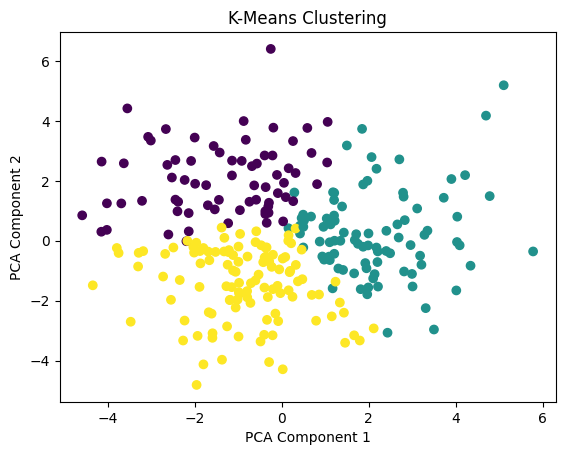

In [76]:
# Reduce to 2 dimensions for visualization
n_components = 6
pca = PCA(n_components=n_components)
reduced_features = pca.fit_transform(normalized_features)
print('Cumulative variance explained by {} principal components: {:.2%}'.format(n_components, np.sum(pca.explained_variance_ratio_)))


# Plot the clusters
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title("K-Means Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [77]:
# Results from pca.components_
dataset_pca = pd.DataFrame(abs(pca.components_), columns=features.columns, index=['PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6'])
print('\n\n', dataset_pca)
    



             gender       age  attractive_important  sincere_important  \
PC_1  3.523652e-18  0.039026              0.081079           0.076201   
PC_2  7.815546e-18  0.040928              0.003799           0.031887   
PC_3  9.534738e-18  0.281743              0.238186           0.231856   
PC_4  2.746064e-18  0.048013              0.181390           0.289184   
PC_5  6.718992e-18  0.237069              0.224506           0.126203   
PC_6  8.051178e-18  0.024560              0.413290           0.123988   

      intellicence_important  funny_important  ambtition_important  \
PC_1                0.022980         0.046925             0.043742   
PC_2                0.026417         0.062734             0.070078   
PC_3                0.069309         0.030337             0.160930   
PC_4                0.231921         0.012998             0.033359   
PC_5                0.096427         0.156291             0.099599   
PC_6                0.053178         0.051663             0.50368

Parameter: {'n_clusters': 2, 'n_init': 'auto'} Score 0.5116874341504152
Parameter: {'n_clusters': 3, 'n_init': 'auto'} Score 0.46019738953830014
Parameter: {'n_clusters': 4, 'n_init': 'auto'} Score 0.3795304765110761
Parameter: {'n_clusters': 5, 'n_init': 'auto'} Score 0.3626776100398638
Parameter: {'n_clusters': 10, 'n_init': 'auto'} Score 0.19385879814715468
Parameter: {'n_clusters': 15, 'n_init': 'auto'} Score 0.20034308055517094
Parameter: {'n_clusters': 20, 'n_init': 'auto'} Score 0.17235597462596866
Parameter: {'n_clusters': 25, 'n_init': 'auto'} Score 0.16227555694253112
Parameter: {'n_clusters': 30, 'n_init': 'auto'} Score 0.1601653256847787
Parameter: {'n_clusters': 35, 'n_init': 'auto'} Score 0.1640835096826781
Parameter: {'n_clusters': 40, 'n_init': 'auto'} Score 0.1718090038393522


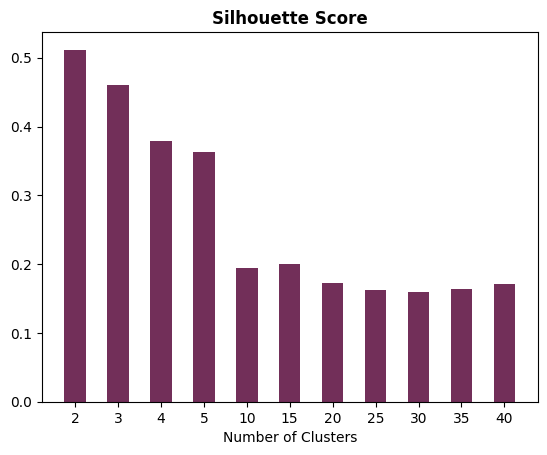

In [80]:

# candidate values for our number of cluster
parameters = [2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40]
# instantiating ParameterGrid, pass number of clusters as input
parameter_grid = ParameterGrid({'n_clusters': parameters, 'n_init': ['auto']})
best_score = -1
kmeans_model = KMeans()     # instantiating KMeans model
silhouette_scores = []
# evaluation based on silhouette_score
for p in parameter_grid:
    kmeans_model.set_params(**p)    # set current hyper parameter
    kmeans_model.fit(data)          # fit model on wine dataset, this will find clusters based on parameter p
    ss = silhouette_score(data, kmeans_model.labels_)   # calculate silhouette_score
    silhouette_scores += [ss]       # store all the scores
    print('Parameter:', p, 'Score', ss)
    # check p which has the best score
    if ss > best_score:
        best_score = ss
        best_grid = p
# plotting silhouette score
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(parameters))
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.show()